In [1]:
%matplotlib notebook

In [2]:
import pyspark

sc = pyspark.sql.SparkSession.Builder().getOrCreate()

## Levanto los archivos

In [3]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from IPython.display import display, HTML
import math

from utils.emissions_normalizer import EmissionsNormalizer

## Utils

In [4]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)


def k_cross_validation(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
        
    kf = KFold(n_splits=k, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train


def show_best_results(results, estimator_name, n=5):
    best_res = sc.sparkContext.parallelize(results).sortBy(lambda x: x['error']).take(n)
    df = pd.DataFrame(list(map(lambda x: x['params'], best_res)))
    df["mean_score_validation"] = list(map(lambda x: x['error'], best_res))
    df["mean_score_training"] = list(map(lambda x: x['error_train'], best_res))
    display(HTML("<h3> {}: top {} combinaciones  </h3>".format(estimator_name, n)))
    display(df.sort_values(by="mean_score_validation", ascending=True).head(n))
    
def regre_grid_search(predictor, params, regre_data, regre_target):
    results = []
    for params in ParameterGrid(params):
        clf = MultiOutputRegressor(predictor(**params))
        res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
def classi_grid_search(predictor, params, classi_data, classi_target):
    results = []
    for params in ParameterGrid(params):
        clf = predictor(**params)
        res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae)
        results.append({'params': params, 'error': np.mean(res_test), 'error_train': np.mean(res_train)})

    show_best_results(results, predictor.__name__)
    
    
from sklearn.model_selection import GroupKFold



### deprecated
def k_cross_validation_separated_points(clf, data, target, get_classifier_mae, k=5):
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    if not isinstance(target, np.ndarray):
        target = np.array(target)
    
    unique_target = np.unique(target, axis=0)

    groups = []
    for h in range(len(target)):
        i,j = np.where(unique_target == target[h])
        if i[0] == i[1]:
            groups.append(i[0])
        else:
            raise Exception('Algo anda mal')

    kf = GroupKFold(n_splits=k)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data, groups=groups):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        clf.fit(X_train, y_train)
        mae = get_classifier_mae(clf.predict(X_test), y_test)
        mae_train = get_classifier_mae(clf.predict(X_train), y_train)
        mae_list.append(mae)
        mae_list_train.append(mae_train)


    return mae_list, mae_list_train



## Map utils

In [5]:
global posicion_antenas
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
nombre_antenas = ["RC1", "RC2", "D1", "D2"] 

global x_0
global y_0

x_0 = 462385.503783397
x_f = 465958.114906211
y_0 = 6109042.35153865
y_f = 6112715.80637111


def normalize_positions(row):
    row['x'] = row['x']-x_0
    row['y'] = row['y']-y_0
    return row


In [6]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd


normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [8]:
clf = MultiOutputRegressor(KNeighborsRegressor(n_neighbors=5, weights='distance'))
#clf = KNeighborsRegressor(n_neighbors=5, weights='distance')



def get_regressor_mae(predictions, real):
    mae = 0
    for i in range(len(predictions)):
        mae += distance(predictions[i], real[i])
    mae = mae/len(predictions)
    return mae


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)

339.110507215288

In [9]:
from sklearn.neural_network import MLPRegressor

In [14]:
clf = MLPRegressor(hidden_layer_sizes=(4,4), max_iter=10000, learning_rate_init=0.001, verbose=True)

res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)

Iteration 1, loss = 1831513.47052998
Iteration 2, loss = 1825191.88970307
Iteration 3, loss = 1817921.02059327
Iteration 4, loss = 1809145.25925997
Iteration 5, loss = 1798518.05642061
Iteration 6, loss = 1785232.91616494
Iteration 7, loss = 1768031.45613141
Iteration 8, loss = 1746824.70522664
Iteration 9, loss = 1720751.63612856
Iteration 10, loss = 1689720.68481676
Iteration 11, loss = 1653589.59952208
Iteration 12, loss = 1611993.28000350
Iteration 13, loss = 1564497.85172169
Iteration 14, loss = 1511205.72798810
Iteration 15, loss = 1452453.86633815
Iteration 16, loss = 1386631.97353605
Iteration 17, loss = 1313411.10711570
Iteration 18, loss = 1233088.71908573
Iteration 19, loss = 1147362.49070167
Iteration 20, loss = 1061101.71946700
Iteration 21, loss = 975575.28203870
Iteration 22, loss = 893606.35862762
Iteration 23, loss = 820573.50199724
Iteration 24, loss = 757356.85959180
Iteration 25, loss = 704026.95097113
Iteration 26, loss = 660150.11429361
Iteration 27, loss = 622790

Iteration 230, loss = 257074.58094444
Iteration 231, loss = 256839.73298086
Iteration 232, loss = 256579.47119306
Iteration 233, loss = 256322.22166628
Iteration 234, loss = 256076.90829250
Iteration 235, loss = 255809.87505787
Iteration 236, loss = 255617.98633140
Iteration 237, loss = 255379.16547020
Iteration 238, loss = 255068.55956188
Iteration 239, loss = 254791.72913245
Iteration 240, loss = 254553.02096411
Iteration 241, loss = 254280.38105044
Iteration 242, loss = 254044.67923243
Iteration 243, loss = 253763.60933194
Iteration 244, loss = 253503.36255502
Iteration 245, loss = 253252.61395649
Iteration 246, loss = 252792.49055760
Iteration 247, loss = 252201.20818346
Iteration 248, loss = 251200.59408957
Iteration 249, loss = 249904.70056040
Iteration 250, loss = 248597.80660491
Iteration 251, loss = 247302.14505315
Iteration 252, loss = 246120.76526801
Iteration 253, loss = 245104.15909412
Iteration 254, loss = 244064.61310946
Iteration 255, loss = 243210.53518067
Iteration 25

Iteration 460, loss = 130875.39322410
Iteration 461, loss = 129717.77788212
Iteration 462, loss = 128683.00212171
Iteration 463, loss = 127533.23516010
Iteration 464, loss = 126465.36279177
Iteration 465, loss = 125310.37804493
Iteration 466, loss = 124204.59761745
Iteration 467, loss = 123120.46305832
Iteration 468, loss = 121988.30740592
Iteration 469, loss = 120843.35155337
Iteration 470, loss = 119754.47222987
Iteration 471, loss = 118556.38434009
Iteration 472, loss = 117403.46239857
Iteration 473, loss = 116331.60797703
Iteration 474, loss = 115150.84474754
Iteration 475, loss = 114009.90116240
Iteration 476, loss = 112858.74879980
Iteration 477, loss = 111710.54098671
Iteration 478, loss = 110608.54546301
Iteration 479, loss = 109425.08184980
Iteration 480, loss = 108327.26773438
Iteration 481, loss = 107004.61411777
Iteration 482, loss = 105867.52679855
Iteration 483, loss = 104627.63081763
Iteration 484, loss = 103468.17485641
Iteration 485, loss = 102227.56752075
Iteration 48

Iteration 703, loss = 50071.88264213
Iteration 704, loss = 50078.02479353
Iteration 705, loss = 49950.85924687
Iteration 706, loss = 49933.03436595
Iteration 707, loss = 49915.37899355
Iteration 708, loss = 49893.64400676
Iteration 709, loss = 49878.53750534
Iteration 710, loss = 49875.15437180
Iteration 711, loss = 49865.30570497
Iteration 712, loss = 49869.87347378
Iteration 713, loss = 49826.55751897
Iteration 714, loss = 49799.53164996
Iteration 715, loss = 49813.21902269
Iteration 716, loss = 49802.11120066
Iteration 717, loss = 49778.54105087
Iteration 718, loss = 49806.92541933
Iteration 719, loss = 49748.40110449
Iteration 720, loss = 49761.66434137
Iteration 721, loss = 49723.45738776
Iteration 722, loss = 49696.74618928
Iteration 723, loss = 49691.34689929
Iteration 724, loss = 49677.06460133
Iteration 725, loss = 49675.98034647
Iteration 726, loss = 49656.32898788
Iteration 727, loss = 49651.26304233
Iteration 728, loss = 49644.55762838
Iteration 729, loss = 49619.85104498
I

Iteration 932, loss = 47972.22280969
Iteration 933, loss = 47967.34209256
Iteration 934, loss = 47961.20646363
Iteration 935, loss = 48053.84699181
Iteration 936, loss = 47930.20317591
Iteration 937, loss = 47958.68068911
Iteration 938, loss = 47970.71794750
Iteration 939, loss = 47924.31397213
Iteration 940, loss = 47944.69831497
Iteration 941, loss = 47922.22914268
Iteration 942, loss = 47921.83071227
Iteration 943, loss = 47972.55111357
Iteration 944, loss = 47972.98743990
Iteration 945, loss = 47961.29412340
Iteration 946, loss = 47867.98964453
Iteration 947, loss = 47864.12591394
Iteration 948, loss = 47846.42507136
Iteration 949, loss = 47835.85727694
Iteration 950, loss = 47838.20445194
Iteration 951, loss = 47853.14803819
Iteration 952, loss = 47885.00038506
Iteration 953, loss = 47858.18544638
Iteration 954, loss = 47839.48026915
Iteration 955, loss = 47923.45384617
Iteration 956, loss = 47828.32551215
Iteration 957, loss = 47832.60840209
Iteration 958, loss = 47839.36769930
I

Iteration 1155, loss = 46971.78873565
Iteration 1156, loss = 46965.11765287
Iteration 1157, loss = 46929.09841484
Iteration 1158, loss = 46904.98250846
Iteration 1159, loss = 46942.96423147
Iteration 1160, loss = 46887.08050916
Iteration 1161, loss = 46892.80025821
Iteration 1162, loss = 46859.33877097
Iteration 1163, loss = 46862.92372799
Iteration 1164, loss = 46885.25503255
Iteration 1165, loss = 46913.19418195
Iteration 1166, loss = 46874.42431170
Iteration 1167, loss = 46890.00051155
Iteration 1168, loss = 46867.47217837
Iteration 1169, loss = 46835.30218677
Iteration 1170, loss = 46910.00208369
Iteration 1171, loss = 46895.53107721
Iteration 1172, loss = 46896.21203324
Iteration 1173, loss = 46847.39013040
Iteration 1174, loss = 46877.15764013
Iteration 1175, loss = 46865.09267688
Iteration 1176, loss = 46891.58551787
Iteration 1177, loss = 46856.70862767
Iteration 1178, loss = 46855.77836694
Iteration 1179, loss = 46834.51783837
Iteration 1180, loss = 46809.27195702
Iteration 11

Iteration 146, loss = 377682.67433708
Iteration 147, loss = 377547.55366952
Iteration 148, loss = 377456.01990241
Iteration 149, loss = 377329.57885374
Iteration 150, loss = 377231.99109148
Iteration 151, loss = 377104.70165400
Iteration 152, loss = 377011.37739328
Iteration 153, loss = 376899.29447629
Iteration 154, loss = 376776.60597474
Iteration 155, loss = 376659.96636695
Iteration 156, loss = 376579.04788051
Iteration 157, loss = 376438.90166708
Iteration 158, loss = 376355.71845686
Iteration 159, loss = 376253.62663109
Iteration 160, loss = 376073.99361027
Iteration 161, loss = 376008.14734789
Iteration 162, loss = 375881.87660107
Iteration 163, loss = 375752.97688333
Iteration 164, loss = 375655.50076757
Iteration 165, loss = 375523.16031915
Iteration 166, loss = 375425.42524782
Iteration 167, loss = 375270.84923995
Iteration 168, loss = 375189.51936633
Iteration 169, loss = 375047.39289358
Iteration 170, loss = 374932.93777731
Iteration 171, loss = 374798.87742266
Iteration 17

Iteration 366, loss = 268732.97314421
Iteration 367, loss = 268308.52412273
Iteration 368, loss = 267996.91395434
Iteration 369, loss = 267551.10176521
Iteration 370, loss = 267044.88645620
Iteration 371, loss = 266666.00887965
Iteration 372, loss = 266243.44135875
Iteration 373, loss = 265841.98424329
Iteration 374, loss = 265523.81386819
Iteration 375, loss = 265018.46064616
Iteration 376, loss = 264629.80156006
Iteration 377, loss = 264337.01181163
Iteration 378, loss = 263815.96806313
Iteration 379, loss = 263389.75978669
Iteration 380, loss = 263059.76272854
Iteration 381, loss = 262625.49416451
Iteration 382, loss = 262176.98191161
Iteration 383, loss = 261771.99218913
Iteration 384, loss = 261371.47479084
Iteration 385, loss = 260961.60133652
Iteration 386, loss = 260512.45514101
Iteration 387, loss = 260124.61461873
Iteration 388, loss = 259703.47652526
Iteration 389, loss = 259299.41769309
Iteration 390, loss = 258896.04107994
Iteration 391, loss = 258477.25850894
Iteration 39

Iteration 594, loss = 140060.69506889
Iteration 595, loss = 139045.45188565
Iteration 596, loss = 138125.50410106
Iteration 597, loss = 137159.26011411
Iteration 598, loss = 136137.24643760
Iteration 599, loss = 135137.41399786
Iteration 600, loss = 134166.50077961
Iteration 601, loss = 133184.43951414
Iteration 602, loss = 132269.92360199
Iteration 603, loss = 131240.71379826
Iteration 604, loss = 130354.00371917
Iteration 605, loss = 129325.23784583
Iteration 606, loss = 128429.47811457
Iteration 607, loss = 127391.30187161
Iteration 608, loss = 126402.02621240
Iteration 609, loss = 125447.80619452
Iteration 610, loss = 124516.30183308
Iteration 611, loss = 123589.92442290
Iteration 612, loss = 122616.19032488
Iteration 613, loss = 121670.59683446
Iteration 614, loss = 120753.16876169
Iteration 615, loss = 119786.19305338
Iteration 616, loss = 118850.03938446
Iteration 617, loss = 117925.91638839
Iteration 618, loss = 117046.37333305
Iteration 619, loss = 116047.13010230
Iteration 62

Iteration 818, loss = 51980.91540703
Iteration 819, loss = 51968.00988364
Iteration 820, loss = 51942.17995490
Iteration 821, loss = 51903.36957184
Iteration 822, loss = 51884.23692499
Iteration 823, loss = 51862.98551268
Iteration 824, loss = 51807.74594934
Iteration 825, loss = 51827.97889374
Iteration 826, loss = 51783.26912273
Iteration 827, loss = 51775.62922567
Iteration 828, loss = 51718.60308953
Iteration 829, loss = 51750.89259732
Iteration 830, loss = 51696.78527165
Iteration 831, loss = 51726.97961738
Iteration 832, loss = 51724.06016540
Iteration 833, loss = 51649.57155846
Iteration 834, loss = 51642.16775675
Iteration 835, loss = 51621.57950333
Iteration 836, loss = 51628.28615735
Iteration 837, loss = 51637.03913113
Iteration 838, loss = 51620.87537896
Iteration 839, loss = 51570.52762988
Iteration 840, loss = 51542.23154864
Iteration 841, loss = 51543.88834860
Iteration 842, loss = 51516.82897389
Iteration 843, loss = 51478.83195584
Iteration 844, loss = 51503.61531702
I

Iteration 1069, loss = 50076.46962151
Iteration 1070, loss = 50078.22452895
Iteration 1071, loss = 50082.46113057
Iteration 1072, loss = 50068.64662169
Iteration 1073, loss = 50112.94058172
Iteration 1074, loss = 50117.00771240
Iteration 1075, loss = 50081.04160570
Iteration 1076, loss = 50059.24965429
Iteration 1077, loss = 50033.39241087
Iteration 1078, loss = 50028.43686509
Iteration 1079, loss = 50035.80925533
Iteration 1080, loss = 50047.07431199
Iteration 1081, loss = 50018.37696429
Iteration 1082, loss = 50048.85741184
Iteration 1083, loss = 50030.66176208
Iteration 1084, loss = 50014.56191010
Iteration 1085, loss = 50047.63737363
Iteration 1086, loss = 50003.60909159
Iteration 1087, loss = 49989.64804361
Iteration 1088, loss = 49989.16613287
Iteration 1089, loss = 49999.62117182
Iteration 1090, loss = 49971.74693579
Iteration 1091, loss = 49970.70816129
Iteration 1092, loss = 49979.80321732
Iteration 1093, loss = 49962.19908277
Iteration 1094, loss = 49974.67532953
Iteration 10

Iteration 1296, loss = 49228.38443031
Iteration 1297, loss = 49222.19218336
Iteration 1298, loss = 49214.23942218
Iteration 1299, loss = 49260.21306439
Iteration 1300, loss = 49253.58103088
Iteration 1301, loss = 49225.57260816
Iteration 1302, loss = 49290.13743296
Iteration 1303, loss = 49232.24244375
Iteration 1304, loss = 49194.88356102
Iteration 1305, loss = 49313.84187144
Iteration 1306, loss = 49275.66110769
Iteration 1307, loss = 49270.64248932
Iteration 1308, loss = 49251.93976696
Iteration 1309, loss = 49228.02683295
Iteration 1310, loss = 49229.36648151
Iteration 1311, loss = 49206.34590813
Iteration 1312, loss = 49261.92616193
Iteration 1313, loss = 49202.58961931
Iteration 1314, loss = 49234.38032928
Iteration 1315, loss = 49201.16409184
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1849704.89512121
Iteration 2, loss = 1848263.21365785
Iteration 3, loss = 1846302.84731452
Iteration 4, loss = 1843628.26683012
It

Iteration 223, loss = 332642.46617097
Iteration 224, loss = 332491.01043130
Iteration 225, loss = 332380.23215136
Iteration 226, loss = 332189.60969255
Iteration 227, loss = 332007.17038610
Iteration 228, loss = 331916.10732378
Iteration 229, loss = 331729.11516962
Iteration 230, loss = 331532.92790663
Iteration 231, loss = 331451.00633966
Iteration 232, loss = 331223.10466749
Iteration 233, loss = 331093.01939412
Iteration 234, loss = 330913.14622597
Iteration 235, loss = 330785.22894961
Iteration 236, loss = 330585.96952462
Iteration 237, loss = 330461.23918821
Iteration 238, loss = 330264.14688285
Iteration 239, loss = 330125.97109382
Iteration 240, loss = 329983.01347413
Iteration 241, loss = 329956.54061800
Iteration 242, loss = 329593.81581752
Iteration 243, loss = 329520.75655000
Iteration 244, loss = 329263.69311910
Iteration 245, loss = 329113.28875097
Iteration 246, loss = 328915.37929464
Iteration 247, loss = 328766.28075036
Iteration 248, loss = 328586.84626168
Iteration 24

Iteration 439, loss = 215278.34925979
Iteration 440, loss = 214310.63353921
Iteration 441, loss = 213367.28514227
Iteration 442, loss = 212284.95727457
Iteration 443, loss = 211317.29979316
Iteration 444, loss = 210341.88820573
Iteration 445, loss = 209321.45860610
Iteration 446, loss = 208257.69475904
Iteration 447, loss = 207237.97969381
Iteration 448, loss = 206164.02554871
Iteration 449, loss = 205243.86994182
Iteration 450, loss = 204310.23417740
Iteration 451, loss = 203052.65823712
Iteration 452, loss = 201935.33466299
Iteration 453, loss = 200811.07614823
Iteration 454, loss = 199692.41301140
Iteration 455, loss = 198646.14196268
Iteration 456, loss = 197526.46350516
Iteration 457, loss = 196384.35843620
Iteration 458, loss = 195327.21044552
Iteration 459, loss = 194124.52770648
Iteration 460, loss = 192960.13054007
Iteration 461, loss = 191927.83161506
Iteration 462, loss = 190682.93661213
Iteration 463, loss = 189608.75480405
Iteration 464, loss = 188482.31736509
Iteration 46

Iteration 659, loss = 51834.87306705
Iteration 660, loss = 51949.98632140
Iteration 661, loss = 51959.81229538
Iteration 662, loss = 51850.84963531
Iteration 663, loss = 51786.55652565
Iteration 664, loss = 51770.27349633
Iteration 665, loss = 51762.69780740
Iteration 666, loss = 51764.69101601
Iteration 667, loss = 51773.31139872
Iteration 668, loss = 51764.67791552
Iteration 669, loss = 51781.24160558
Iteration 670, loss = 51774.69703434
Iteration 671, loss = 51790.90108165
Iteration 672, loss = 51714.66541927
Iteration 673, loss = 51754.78636800
Iteration 674, loss = 51776.69601634
Iteration 675, loss = 51759.62086199
Iteration 676, loss = 51713.34071403
Iteration 677, loss = 51724.02925339
Iteration 678, loss = 51763.84796895
Iteration 679, loss = 51831.07282761
Iteration 680, loss = 51707.05291918
Iteration 681, loss = 51703.91347952
Iteration 682, loss = 51690.69959022
Iteration 683, loss = 51707.32829401
Iteration 684, loss = 51674.11969105
Iteration 685, loss = 51696.88815445
I

Iteration 150, loss = 256690.03803116
Iteration 151, loss = 255969.93715070
Iteration 152, loss = 255226.44657799
Iteration 153, loss = 254561.45847111
Iteration 154, loss = 253889.90730489
Iteration 155, loss = 253205.98851571
Iteration 156, loss = 252556.49564501
Iteration 157, loss = 251881.42485455
Iteration 158, loss = 251260.76468014
Iteration 159, loss = 250704.40766348
Iteration 160, loss = 250111.27686963
Iteration 161, loss = 249598.57010219
Iteration 162, loss = 249008.83463562
Iteration 163, loss = 248505.25595636
Iteration 164, loss = 248000.63299745
Iteration 165, loss = 247478.73578762
Iteration 166, loss = 247018.02699851
Iteration 167, loss = 246709.96478144
Iteration 168, loss = 246259.06413064
Iteration 169, loss = 245811.08395472
Iteration 170, loss = 245410.44962419
Iteration 171, loss = 245114.68131972
Iteration 172, loss = 244684.35640930
Iteration 173, loss = 244397.00437328
Iteration 174, loss = 244099.64945128
Iteration 175, loss = 243691.63493164
Iteration 17

Iteration 374, loss = 180799.15660366
Iteration 375, loss = 180237.28347698
Iteration 376, loss = 179650.07094533
Iteration 377, loss = 178968.50465933
Iteration 378, loss = 178342.59444922
Iteration 379, loss = 177790.84239889
Iteration 380, loss = 177134.84293631
Iteration 381, loss = 176549.78551321
Iteration 382, loss = 175835.64583326
Iteration 383, loss = 175213.50700519
Iteration 384, loss = 174576.64248620
Iteration 385, loss = 173852.06729213
Iteration 386, loss = 173183.55895310
Iteration 387, loss = 172649.62996181
Iteration 388, loss = 171968.84484056
Iteration 389, loss = 171260.33091816
Iteration 390, loss = 170513.08794505
Iteration 391, loss = 169733.39297309
Iteration 392, loss = 169017.66156598
Iteration 393, loss = 168340.66755968
Iteration 394, loss = 167581.34157392
Iteration 395, loss = 166891.47576883
Iteration 396, loss = 166102.13712888
Iteration 397, loss = 165456.36763809
Iteration 398, loss = 164596.51542606
Iteration 399, loss = 163909.42688725
Iteration 40

Iteration 608, loss = 47535.04807774
Iteration 609, loss = 47539.61746518
Iteration 610, loss = 47530.43063320
Iteration 611, loss = 47425.47562099
Iteration 612, loss = 47349.74545995
Iteration 613, loss = 47354.33592545
Iteration 614, loss = 47316.63717072
Iteration 615, loss = 47275.99316514
Iteration 616, loss = 47261.42427610
Iteration 617, loss = 47234.10298592
Iteration 618, loss = 47137.76933317
Iteration 619, loss = 47112.68912305
Iteration 620, loss = 47140.78091322
Iteration 621, loss = 47110.73813466
Iteration 622, loss = 47043.74586499
Iteration 623, loss = 47022.72425435
Iteration 624, loss = 46992.02201202
Iteration 625, loss = 46998.34905071
Iteration 626, loss = 46967.60448566
Iteration 627, loss = 46907.83353575
Iteration 628, loss = 46910.84922111
Iteration 629, loss = 46855.93354165
Iteration 630, loss = 46836.67121987
Iteration 631, loss = 46815.18797736
Iteration 632, loss = 46820.37630840
Iteration 633, loss = 46792.46287317
Iteration 634, loss = 46811.60382447
I

Iteration 11, loss = 1807421.54739867
Iteration 12, loss = 1793792.73505897
Iteration 13, loss = 1775522.40787326
Iteration 14, loss = 1751353.76965093
Iteration 15, loss = 1720786.09973876
Iteration 16, loss = 1682991.60548121
Iteration 17, loss = 1638399.11359805
Iteration 18, loss = 1587510.55165316
Iteration 19, loss = 1529933.35039113
Iteration 20, loss = 1466079.46319492
Iteration 21, loss = 1397848.48610556
Iteration 22, loss = 1326718.92835468
Iteration 23, loss = 1253703.98703341
Iteration 24, loss = 1181321.73422970
Iteration 25, loss = 1109999.18209441
Iteration 26, loss = 1041966.71891563
Iteration 27, loss = 978297.36275339
Iteration 28, loss = 919721.91442178
Iteration 29, loss = 867328.85307629
Iteration 30, loss = 821067.55192371
Iteration 31, loss = 781185.74402021
Iteration 32, loss = 746763.62232614
Iteration 33, loss = 717561.17537857
Iteration 34, loss = 692613.41864297
Iteration 35, loss = 670774.52499613
Iteration 36, loss = 651758.75207955
Iteration 37, loss = 6

Iteration 244, loss = 285303.07754658
Iteration 245, loss = 284904.96122904
Iteration 246, loss = 284540.50591978
Iteration 247, loss = 284181.42990961
Iteration 248, loss = 283822.92514558
Iteration 249, loss = 283449.05811595
Iteration 250, loss = 283082.67901207
Iteration 251, loss = 282753.64910028
Iteration 252, loss = 282375.04038879
Iteration 253, loss = 281993.21537349
Iteration 254, loss = 281685.16731119
Iteration 255, loss = 281350.49688982
Iteration 256, loss = 280977.73088511
Iteration 257, loss = 280653.79659055
Iteration 258, loss = 280382.75310485
Iteration 259, loss = 279992.19243299
Iteration 260, loss = 279629.52778064
Iteration 261, loss = 279299.10737688
Iteration 262, loss = 278965.70879370
Iteration 263, loss = 278670.83444089
Iteration 264, loss = 278415.59825158
Iteration 265, loss = 278009.69031814
Iteration 266, loss = 277685.44403686
Iteration 267, loss = 277432.57373580
Iteration 268, loss = 277120.14790269
Iteration 269, loss = 276781.00497803
Iteration 27

Iteration 487, loss = 175451.83499465
Iteration 488, loss = 174652.79460128
Iteration 489, loss = 173721.11102986
Iteration 490, loss = 172879.39529175
Iteration 491, loss = 172104.99908221
Iteration 492, loss = 171253.24176669
Iteration 493, loss = 170464.94896599
Iteration 494, loss = 169606.43338052
Iteration 495, loss = 168791.86200486
Iteration 496, loss = 167900.12256129
Iteration 497, loss = 167188.25607064
Iteration 498, loss = 166384.72594931
Iteration 499, loss = 165355.44663645
Iteration 500, loss = 164506.38053312
Iteration 501, loss = 163593.02662969
Iteration 502, loss = 162683.30513485
Iteration 503, loss = 161770.32163556
Iteration 504, loss = 160895.55783470
Iteration 505, loss = 160081.93091734
Iteration 506, loss = 159176.12719468
Iteration 507, loss = 158186.79684639
Iteration 508, loss = 157233.71386443
Iteration 509, loss = 156259.44817545
Iteration 510, loss = 155338.50951347
Iteration 511, loss = 154384.27511076
Iteration 512, loss = 153562.43138895
Iteration 51

Iteration 720, loss = 54441.90792674
Iteration 721, loss = 54426.28547551
Iteration 722, loss = 54414.51194252
Iteration 723, loss = 54395.93115170
Iteration 724, loss = 54347.07822015
Iteration 725, loss = 54340.66752333
Iteration 726, loss = 54355.38299226
Iteration 727, loss = 54311.61427117
Iteration 728, loss = 54328.63175026
Iteration 729, loss = 54253.02857520
Iteration 730, loss = 54276.68467089
Iteration 731, loss = 54268.91585896
Iteration 732, loss = 54261.62916295
Iteration 733, loss = 54258.57004672
Iteration 734, loss = 54184.21925157
Iteration 735, loss = 54159.58719266
Iteration 736, loss = 54144.38483577
Iteration 737, loss = 54160.38592041
Iteration 738, loss = 54138.04489327
Iteration 739, loss = 54128.48065485
Iteration 740, loss = 54096.91808514
Iteration 741, loss = 54117.61526928
Iteration 742, loss = 54067.59480831
Iteration 743, loss = 54055.01216367
Iteration 744, loss = 54019.88012642
Iteration 745, loss = 54001.31951347
Iteration 746, loss = 54014.30097994
I

Iteration 961, loss = 48316.10266961
Iteration 962, loss = 48273.89302356
Iteration 963, loss = 48271.93904738
Iteration 964, loss = 48241.92723367
Iteration 965, loss = 48223.18257714
Iteration 966, loss = 48185.04054810
Iteration 967, loss = 48176.55127492
Iteration 968, loss = 48123.73227216
Iteration 969, loss = 48084.47987493
Iteration 970, loss = 48059.03231297
Iteration 971, loss = 48039.55823528
Iteration 972, loss = 48066.82124625
Iteration 973, loss = 47991.14928502
Iteration 974, loss = 47997.52449909
Iteration 975, loss = 47946.85085827
Iteration 976, loss = 47923.10649483
Iteration 977, loss = 47926.93321937
Iteration 978, loss = 47889.01054876
Iteration 979, loss = 47870.20029485
Iteration 980, loss = 47861.26025047
Iteration 981, loss = 47833.86384930
Iteration 982, loss = 47816.21553020
Iteration 983, loss = 47767.28859910
Iteration 984, loss = 47794.80687074
Iteration 985, loss = 47770.24768082
Iteration 986, loss = 47735.95035085
Iteration 987, loss = 47716.36513205
I

Iteration 1179, loss = 45621.06250003
Iteration 1180, loss = 45614.46473082
Iteration 1181, loss = 45568.69233206
Iteration 1182, loss = 45601.44779616
Iteration 1183, loss = 45527.68497328
Iteration 1184, loss = 45637.40428080
Iteration 1185, loss = 45541.43072400
Iteration 1186, loss = 45534.17285900
Iteration 1187, loss = 45542.59103599
Iteration 1188, loss = 45544.57581462
Iteration 1189, loss = 45509.38326080
Iteration 1190, loss = 45524.46895037
Iteration 1191, loss = 45562.16262544
Iteration 1192, loss = 45505.25451245
Iteration 1193, loss = 45507.52075226
Iteration 1194, loss = 45477.78349220
Iteration 1195, loss = 45513.36019266
Iteration 1196, loss = 45486.12772974
Iteration 1197, loss = 45463.82457383
Iteration 1198, loss = 45538.18039548
Iteration 1199, loss = 45476.11088887
Iteration 1200, loss = 45449.58441897
Iteration 1201, loss = 45485.65853342
Iteration 1202, loss = 45470.65380645
Iteration 1203, loss = 45456.80814590
Iteration 1204, loss = 45439.46381363
Iteration 12

383.78037319800563

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
clf = MultiOutputRegressor(GradientBoostingRegressor())


res_test, res_train = k_cross_validation(clf, regre_data, regre_target, get_regressor_mae, k=5)
np.mean(res_test)


323.43348637185005

### Clasificacion de puntos

In [ ]:
classi_data, classi_target = normalizer.get_classification_dataframes(data)

In [28]:
global dict_coordenadas
dict_coordenadas = points_recep.map(lambda x: (x['Punto'],(x['x'], x['y']))).collectAsMap()



def get_classifier_mae(predictions, real):
    sum_error = 0
    count = 0
    for i in range(len(predictions)):
        pred_position = dict_coordenadas[predictions[i]]
        real_position = dict_coordenadas[real[i]]
        sum_error += distance(pred_position, real_position)
        count += 1
    return sum_error/count
    


    

clf = KNeighborsClassifier(n_neighbors=5, weights='distance')
res_test, res_train = k_cross_validation(clf, classi_data, np.array(classi_target).ravel(), get_classifier_mae, 50)
#res_test, res_train = k_cross_validation_separated_points(clf, classi_data, classi_target, get_classifier_mae, 50)

np.mean(res_test)

388.27945375361145

## Clasificación de regiones + regresion

In [62]:
def get_region(point):
    x = point['x']
    y = point['y']
    return '{}_{}'.format(x%500, y%500)


def evaluate_classi_regre(classifier, regressor, all_emissions, get_region):
    cr_target = pd.DataFrame(all_emissions.map(get_region).collect())
    cr_data = pd.DataFrame(all_emissions.map(lambda x: x['data']).collect())
    r_target = pd.DataFrame(all_emissions.map(lambda x: [x['x'], x['y']]).collect())

    data = np.array(cr_data)
    target = np.array(cr_target).ravel()
    r_target_np = np.array(r_target)


    kf = KFold(n_splits=5, shuffle=True)
    mae_list = []
    mae_list_train = []
    for train_index, test_index in kf.split(data):
        X_train, X_test = data[train_index], data[test_index]
        y_train, y_test = target[train_index], target[test_index]

        classifier.fit(X_train, y_train)

        label_list = classifier.predict_proba(X_train)

        regressor.fit(label_list, r_target_np[train_index])

        c_predictions = classifier.predict_proba(X_test)
        r_predictions = regressor.predict(c_predictions)
        mae = get_regressor_mae(r_predictions, r_target_np[test_index])
        mae_list.append(mae)
        
        c_predictions = classifier.predict_proba(X_train)
        r_predictions = regressor.predict(c_predictions)
        mae_train = get_regressor_mae(r_predictions, r_target_np[train_index])
        mae_list_train.append(mae_train)

    print(np.mean(mae_list))
    print(np.mean(mae_list_train))

evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), data, get_region) 

336.89186868581817
299.12923602882836


In [63]:
evaluate_classi_regre(KNeighborsClassifier(weights='uniform', n_neighbors=15, p=1), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), data, get_region)


335.0499838068325
311.57665936082356


## Clasificación de regiones + regresion with kd-tree

In [31]:
import kdtree

global tree
tree = kdtree.create(regre_target.drop_duplicates().values.tolist())

def get_region_kd(point):
    max_height = 8
    coordinates = (point['x'], point['y'])
    i = 0
    region = ''
    subtree = tree
    while i < max_height:
        assert subtree.is_balanced
        axis = subtree.axis
        if coordinates[axis] < subtree.data[axis]:
            subtree = subtree.left
            region = region+'0'
        else:
            subtree = subtree.right
            region = region+'1'
        i += 1
    return region


evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), data, get_region_kd) 
    

337.73929874854883


In [64]:
evaluate_classi_regre(KNeighborsClassifier(weights='uniform', n_neighbors=15, p=1), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), data, get_region_kd)

330.71599124456935
306.0863126605031


### Regression grid search

In [32]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}

regre_grid_search(KNeighborsRegressor, knn_params, regre_data, regre_target)
 


,n_neighbors,p,weights,mean_score_validation,mean_score_training
0,15,1,uniform,321.962504,307.284723
1,15,2,uniform,322.175444,307.355809
2,10,1,uniform,322.534422,305.232655
3,20,1,uniform,322.891255,309.307001
4,25,2,uniform,323.276877,312.612667


In [33]:
gboost_params = {
    #"loss" : ["ls", "lad", "huber", "quantile"] ,
    "learning_rate" : [0.01, 0.005, 0.05, 0.02, 0.1],
    "n_estimators" : np.arange(400, 1000, 200),
    "max_depth": np.arange(2,6),
}

regre_grid_search(GradientBoostingRegressor, gboost_params, regre_data, regre_target)


,learning_rate,max_depth,n_estimators,mean_score_validation,mean_score_training
0,0.01,5,800,316.496634,295.584968
1,0.01,5,600,317.404678,299.183555
2,0.02,5,800,317.599097,284.365221
3,0.02,5,400,317.902501,295.103262
4,0.05,5,400,317.943860,279.860959


In [39]:
import warnings
warnings.filterwarnings(action='ignore')

In [40]:


from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

regre_grid_search(SVR, {}, regre_data, regre_target)
regre_grid_search(DecisionTreeRegressor, {}, regre_data, regre_target)


,mean_score_validation,mean_score_training
0,592.802337,591.591928


,mean_score_validation,mean_score_training
0,336.344491,228.355227


### Classification grid search

In [41]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 4),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}


classi_grid_search(KNeighborsClassifier, knn_params, classi_data, classi_target)

,n_neighbors,p,weights,mean_score_validation,mean_score_training
0,29,1,distance,378.769677,266.631741
1,33,1,distance,380.131884,268.244514
2,25,2,distance,381.108815,269.737304
3,13,1,distance,381.158985,272.306848
4,33,2,distance,382.646996,267.819461


### Classi + regre grid search

In [ ]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}
try:
    for params_regre in ParameterGrid(knn_params):
        for params_classi in ParameterGrid(knn_params):
            #evaluate_classi_regre(KNeighborsClassifier(), KNeighborsRegressor(), points) 
            print(params_classi, params_regre)
            evaluate_classi_regre(KNeighborsClassifier(**params_classi), KNeighborsRegressor(**params_regre), all_emissions, get_region)
except KeyboardInterrupt:
    print('finished by user')
## El optimo parece estar muy cerca de los parametros default

In [55]:
knn_params = {
    "n_neighbors" : np.arange(5, 40, 5),
    "weights" : ["uniform", "distance"],
    "p" : [1, 2]
}


try:
    for params_classi in ParameterGrid(knn_params):
        print(params_classi)
        evaluate_classi_regre(KNeighborsClassifier(**params_classi), MultiOutputRegressor(GradientBoostingRegressor(learning_rate=0.01, n_estimators=800, max_depth=5)), all_emissions, get_region)
except KeyboardInterrupt:
    print('finished by user')
## El optimo parece estar muy cerca de los parametros default

{'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
371.7385268526654
{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
398.11718032047474
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
370.6833494969189
{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
399.0513526068761
{'n_neighbors': 10, 'p': 1, 'weights': 'uniform'}
343.6261645087796
{'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
391.330570181036
{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}
343.1068298788459
{'n_neighbors': 10, 'p': 2, 'weights': 'distance'}
388.68108578836916
{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
334.53168022451564
{'n_neighbors': 15, 'p': 1, 'weights': 'distance'}
386.9925307255213
{'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
334.64892825023946
{'n_neighbors': 15, 'p': 2, 'weights': 'distance'}
387.84829958621094
{'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}
finished by user


In [50]:
#{'n_neighbors': 15, 'p': 1, 'weights': 'uniform'}
#334.53168022451564

(4356, 2)

# Error analysis

### Mapa con ejemplos de predicciones

In [16]:
def show_prediction_map_examples(predictions, real_points):
    all_points_pos = pd.DataFrame(points_recep.map(lambda p: {'x': p['x'], 'y': p['y']}).map(normalize_positions).collect())
    ax = all_points_pos.plot.scatter(x='x', y='y',c='#96EAE1')
    for antenna in range(4):
        pos_antena = posicion_antenas[antenna]
        name = nombre_antenas[antenna]
        plt.plot(pos_antena[0]-x_0, pos_antena[1]-y_0, "dy")
        ax.annotate(name, xy=(pos_antena[0]-x_0, pos_antena[1]-y_0), textcoords='data') 

    plt.ylim(0,y_f-y_0)
    plt.xlim(0,x_f-x_0)

    
    for i in range(len(predictions)):
        predicted_point = predictions[i]
        real_point = real_points[i]

        if all(predicted_point == real_point):
            plt.scatter(predicted_point[0], predicted_point[1], c='g', s=15)
        else:
            
            plt.scatter(predicted_point[0], predicted_point[1], c='r', s=15)
            plt.scatter(real_point[0], real_point[1], c='b', s=15)

            ax.arrow(real_point[0], real_point[1], predicted_point[0]-real_point[0], predicted_point[1]-real_point[1], head_width=30, head_length=30, fc='k', ec='k', length_includes_head=True)
        
        


<IPython.core.display.Javascript object>


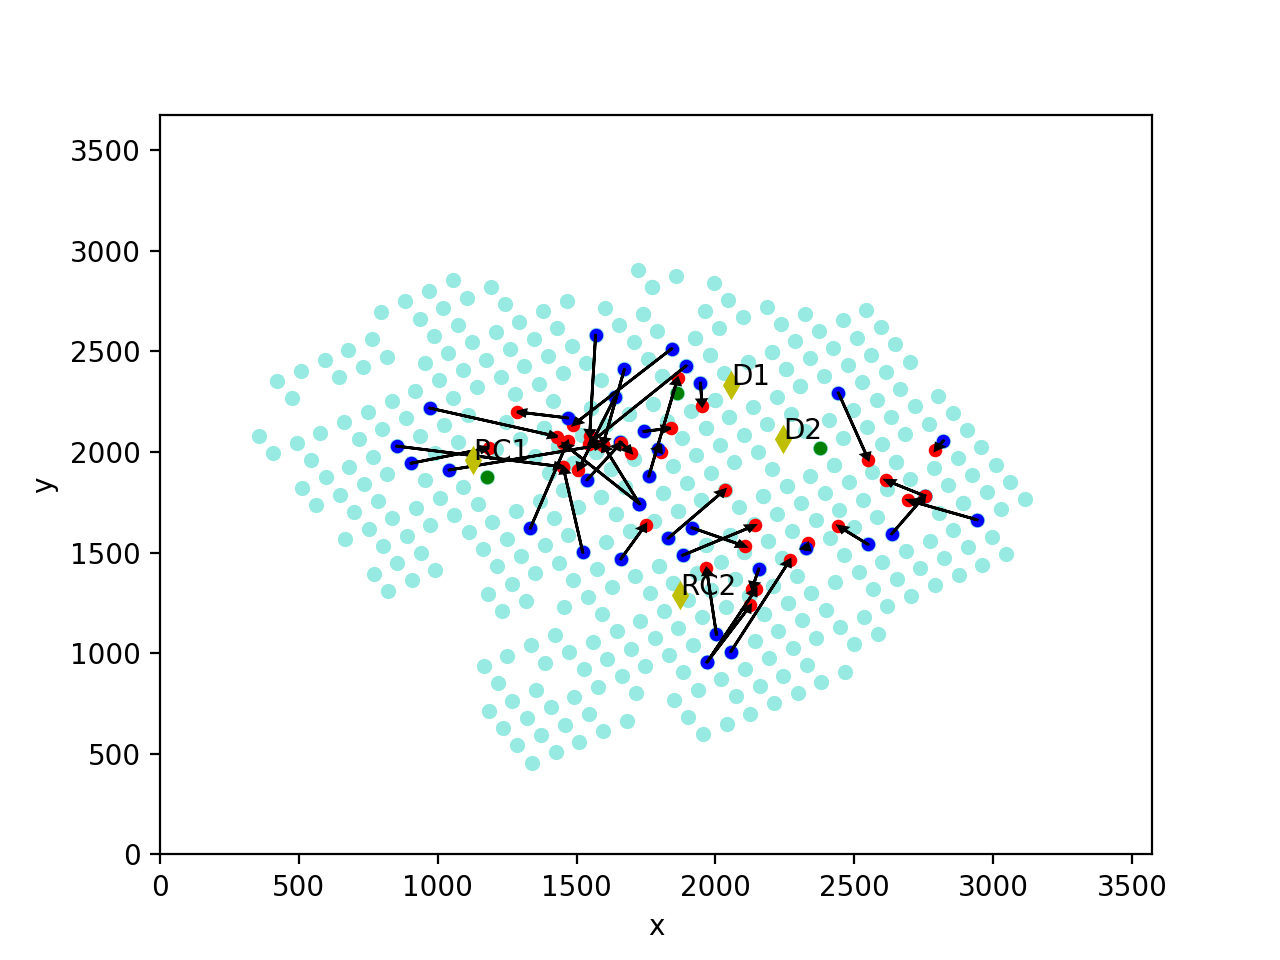

In [17]:
clf = KNeighborsRegressor(n_neighbors=5, weights='distance')
X_train, X_test, y_train, y_test = train_test_split(regre_data, regre_target, test_size=0.007)


clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))

### Mapa con ejemplos de predicciones por punto

examining points [426, 304, 216]


<IPython.core.display.Javascript object>


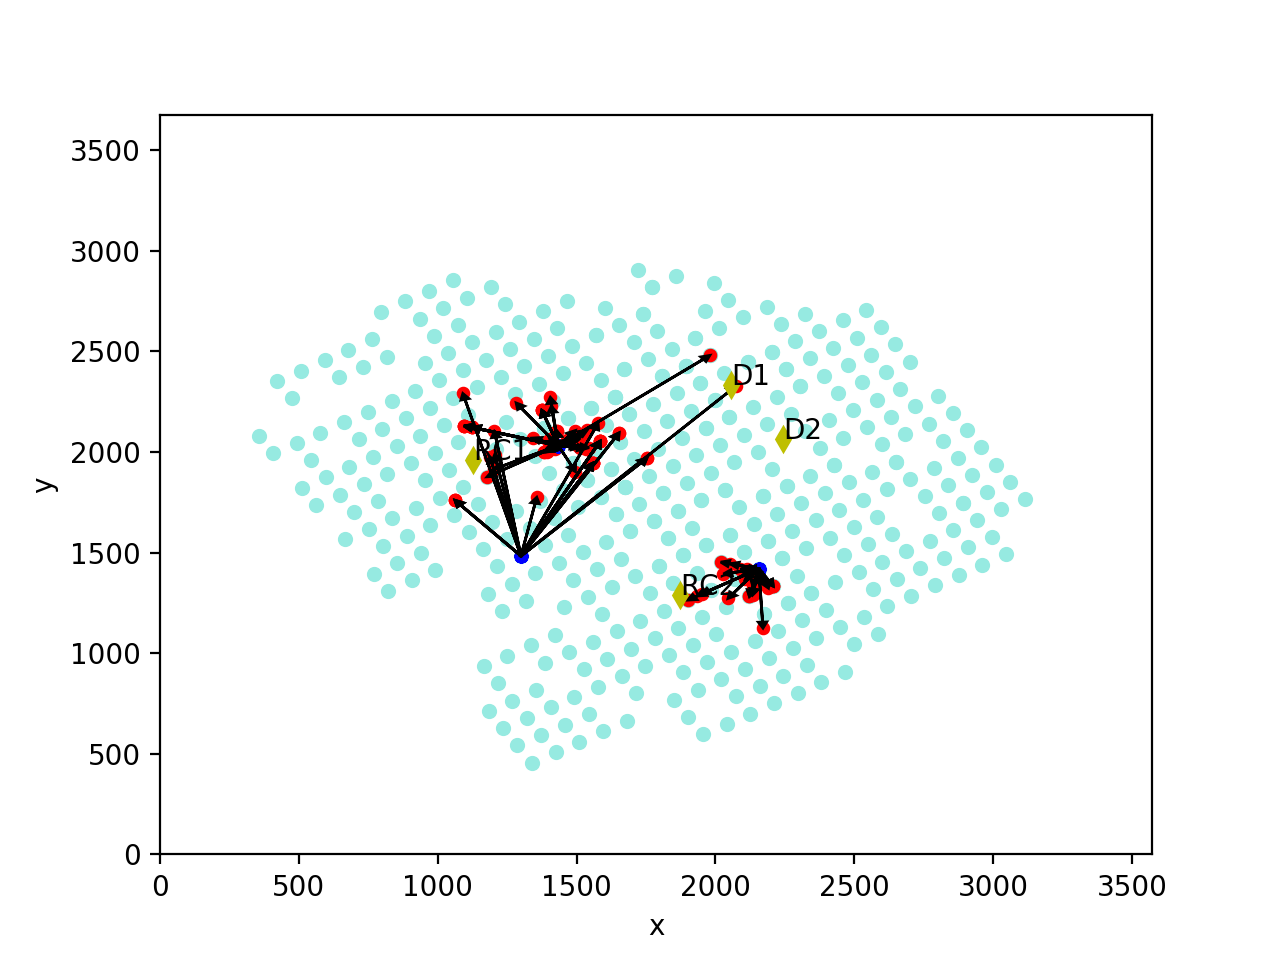

In [18]:
n = 3
sample_points = all_emissions.map(lambda x: x['point']).takeSample(False, n)
print('examining points', sample_points)

X_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: x['data']).collect())
y_train = pd.DataFrame(all_emissions.filter(lambda x: x['point'] not in sample_points).map(lambda x: [x['x'], x['y']]).collect())

X_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: x['data']).collect())
y_test = pd.DataFrame(all_emissions.filter(lambda x: x['point'] in sample_points).map(lambda x: [x['x'], x['y']]).collect())




clf = KNeighborsRegressor(n_neighbors=5, weights='distance')

clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

show_prediction_map_examples(predictions, np.array(y_test))